### Filter Options by Moneyness


In this analysis we include only options with a certain level of moneyness. That is, options far away from the strike price behave differently than options that are closer, and the prior analysis failed to incorporate that understanding. 

In [1]:
import pandas as pd
import numpy as np 
import  pandas_datareader as pdr
from pandas_datareader.yahoo.options import Options
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.4f}'.format
import scipy.stats as stats
import pymc3 as pm
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-muted')
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import datetime as dt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

### Functions

In [2]:
def create_spread_percent(df):
    return (df.assign(Spread_Pct = lambda df: df.Spread / df.Ask))

def filter_by_moneyness(df, pct_cutoff=0.2):
    crit1 = (1-pct_cutoff)*df.Strike < df.Underlying_Price
    crit2 = df.Underlying_Price < (1+pct_cutoff)*df.Strike
    return (df.loc[crit1 & crit2].reset_index(drop=True))

def options_(options_df):
    options_df['Spread'] = options_df['Ask'] - options_df['Bid']
    options_df['DateToday'] = dt.date.today()
    options_df['Expiry'] = pd.to_datetime(options_df.Expiry)
    options_df['DateToday'] = pd.to_datetime(options_df.DateToday)
    options_df['DaysToExpiration'] = (options_df['Expiry'] - options_df['DateToday']).dt.days
    options_df["Intrinsic_Value"] = options_df['Strike']-options_df['Underlying_Price']
    options_df=options_df.dropna()
    return options_df

def custom_describe(df, nidx=3, nfeats=20):
    ''' Concat transposed topN rows, numerical desc & dtypes '''

    print(df.shape)
    nrows = df.shape[0]
    
    rndidx = np.random.randint(0,len(df),nidx)
    dfdesc = df.describe().T

    for col in ['mean','std']:
        dfdesc[col] = dfdesc[col].apply(lambda x: np.round(x,2))
 
    dfout = pd.concat((df.iloc[rndidx].T, dfdesc, df.dtypes), axis=1, join='outer')
    dfout = dfout.loc[df.columns.values]
    dfout.rename(columns={0:'dtype'}, inplace=True)
    
    # add count nonNAN, min, max for string cols
    nan_sum = df.isnull().sum()
    dfout['count'] = nrows - nan_sum
    dfout['min'] = df.min().apply(lambda x: x[:6] if type(x) == str else x)
    dfout['max'] = df.max().apply(lambda x: x[:6] if type(x) == str else x)
    dfout['nunique'] = df.apply(pd.Series.nunique)
    dfout['nan_count'] = nan_sum
    dfout['pct_nan'] = nan_sum / nrows
    
    return dfout.iloc[:nfeats, :]

### Data

In [3]:
options_df=pd.read_excel("../data/option_data/xlsx/sp500_options.xlsx")
options_df=options_df.drop("Unnamed: 0", axis=1)

In [4]:
options_df=options_(options_df)

In [5]:
options_df=create_spread_percent(options_df)

### Filter Options 

In [6]:
data = filter_by_moneyness(options_df)

data_describe = custom_describe(data)
data_describe

(85853, 17)


,9190,37121,65172,count,mean,std,min,25%,50%,75%,max,dtype,nunique,nan_count,pct_nan
Strike,"3,180.0000",220.0000,160.0000,85853,391.4000,688.3600,9.0000,70.0000,142.0000,320.0000,"3,985.0000",float64,1195,0,0.0000
Expiry,2021-07-16 00:00:00,2021-04-16 00:00:00,2021-02-26 00:00:00,85853,nan,nan,2021-02-26 00:00:00,nan,nan,nan,2023-03-17 00:00:00,datetime64[ns],25,0,0.0000
Type,call,call,call,85853,nan,nan,call,nan,nan,nan,put,object,2,0,0.0000
Last,291.0600,2.4500,0.4000,85853,27.1200,69.6200,0.0100,1.6500,6.0000,20.0000,"1,418.3500",float64,10267,0,0.0000
Bid,278.6000,1.6000,0.2500,85853,26.1400,69.9200,0.0000,1.1000,5.2500,18.2000,"1,629.0000",float64,5568,0,0.0000
Ask,280.3000,2.3000,0.4000,85853,27.5800,71.1500,0.0000,1.6000,6.0000,20.0000,"1,648.5000",float64,5589,0,0.0000
Chg,-22.4400,-2.2500,-0.4200,85853,-0.3200,9.7900,-327.0000,-0.1400,0.0000,0.0000,311.3600,float64,10368,0,0.0000
Vol,3.0000,2.0000,72.0000,85853,108.4800,863.9500,0.0000,2.0000,5.0000,22.0000,"73,568.0000",float64,2253,0,0.0000
Open_Int,9.0000,49.0000,7.0000,85853,565.4400,"3,345.4400",0.0000,7.0000,37.0000,192.0000,"269,766.0000",float64,5228,0,0.0000
IV,0.3433,0.3479,0.7529,85853,0.4100,0.1700,0.0000,0.3091,0.3746,0.4844,4.9924,float64,19723,0,0.0000


### Bid-Ask Spread Percentage Analysis

In [7]:
sprd_by_dtm = (data.groupby(['Symbol', 'DaysToExpiration', 'Type'],
                            as_index=False)['Spread_Pct'].median()
               .groupby(['DaysToExpiration', 'Type'], as_index=False).median()
               .assign(bins = lambda x: pd.qcut(x.DaysToExpiration, 10, labels=False)))
sprd_by_dtm['DaysToExpiration'] = sprd_by_dtm['DaysToExpiration'].astype(int)
sprd_by_dtm.sample(5)

,DaysToExpiration,Type,Spread_Pct,bins
22,205,call,0.0652,4
29,296,put,0.0790,6
11,36,put,0.1621,2
16,114,call,0.0670,3
20,177,call,0.0726,4


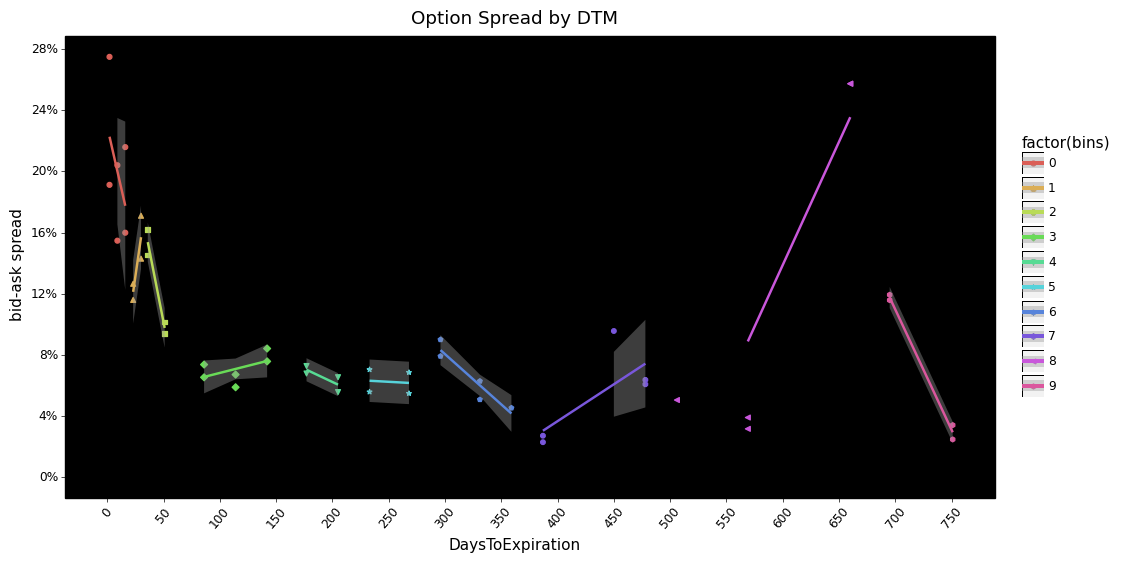

In [9]:
def plot_spread_dtm(sprd_by_dtm):
    """
    given df plot scatter with regression line
    
    # Params
        df: pd.DataFrame()
    # Returns
        g: plotnine figure
    """
    g = (pn.ggplot(sprd_by_dtm, pn.aes('DaysToExpiration', 'Spread_Pct', color='factor(bins)'))
         + pn.geom_point(pn.aes(shape='factor(bins)'))
         + pn.stat_smooth(method='glm')
         + pn.scale_y_continuous(breaks=mzb.mpl_breaks(),
                                 labels=mzf.percent_format(),
                                 limits=(0, sprd_by_dtm.Spread_Pct.max()))
         + pn.scale_x_continuous(breaks=range(0, sprd_by_dtm.DaysToExpiration.max(), 50),
                                              limits=(0, sprd_by_dtm.DaysToExpiration.max()))
         + pn.theme_linedraw()
         + pn.theme(figure_size=(12,6), panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50),) 
         + pn.ylab('bid-ask spread')
         + pn.ggtitle('Option Spread by DTM'))
    return g

# ------------------------------
# Example use of func for both calls and puts

g = plot_spread_dtm(sprd_by_dtm)
g.save(filename='../plots/call-put option bid-ask spreads - daysToExpiration scatter plot-PERCENT.png')
g.draw();    


### How do bid-ask spreads vary with volume? 

In [49]:
grp_cols = ['Symbol', 'DaysToExpiration', 'Type']
agg_cols = ['Spread_Pct', 'Open_Int', 'Vol', 'IV', 'Intrinsic_Value']
median_sprd = data.groupby(grp_cols, as_index=False)[agg_cols].median()

test_syms = ['INTC', 'MSFT', 'AMD', 'NVDA', 'AMZN', 'TSLA', 'GOOGL', 'GOOG']
sel_med_sprd = (median_sprd.query('Symbol in @test_syms')
                .dropna(subset=['Spread_Pct', 'Open_Int']))

# to plot symbols have to cast to type str
sel_med_sprd.Symbol = sel_med_sprd.Symbol.astype(str)
sel_med_sprd.head()
sel_med_sprd.info()

,Symbol,DaysToExpiration,Type,Spread_Pct,Open_Int,Vol,IV,Intrinsic_Value
501,AMD,2.0000,call,0.0833,"1,004.0000",507.0000,0.5176,5.7899
502,AMD,2.0000,put,0.0370,622.0000,100.0000,0.2715,4.2899
503,AMD,9.0000,call,0.0673,478.0000,118.0000,0.4578,5.7800
504,AMD,9.0000,put,0.0245,327.5000,98.5000,0.3628,4.5300
505,AMD,16.0000,call,0.1188,161.0000,63.0000,0.4727,5.7800


<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 501 to 6602
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Symbol            264 non-null    object 
 1   DaysToExpiration  264 non-null    float64
 2   Type              264 non-null    object 
 3   Spread_Pct        264 non-null    float64
 4   Open_Int          264 non-null    float64
 5   Vol               264 non-null    float64
 6   IV                264 non-null    float64
 7   Intrinsic_Value   264 non-null    float64
dtypes: float64(6), object(2)
memory usage: 18.6+ KB


In [50]:
def plot_log_points(df, x, y, color='factor(Symbol)', size='Open_Int'):
    g = (pn.ggplot(df, pn.aes(x, y, color=color))
         + pn.geom_point(pn.aes(size=size))
         + pn.scale_x_log10(breaks=[0,0.5,1,10,100,250,500,750,1_000])
         + pn.theme_linedraw()
         + pn.theme(figure_size=(12,6), panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50))
         + pn.scale_y_continuous(breaks=range(0, int(df.Spread_Pct.max()+2)),
                                 labels=mzf.currency_format(), limits=(0, df.Spread_Pct.max()))
         + pn.ylab('bid-ask spread'))
    return g

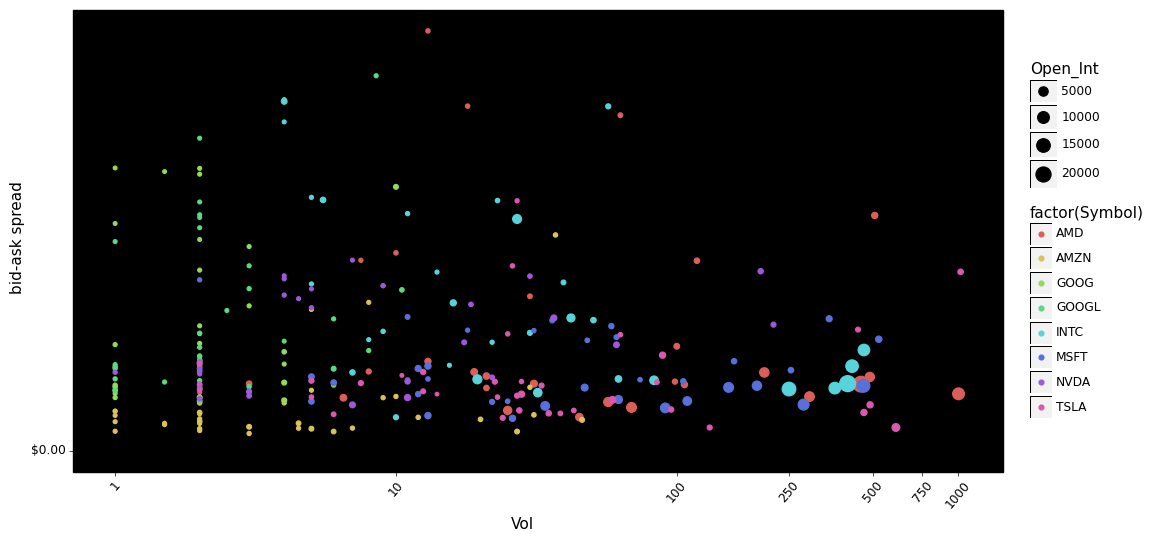

In [51]:
# ------------------------------
df = sel_med_sprd.copy()
# example with both call and puts
g = plot_log_points(sel_med_sprd, x='Vol', y='Spread_Pct')
g.save(filename='../plots/call-put option bid-ask spreads - volume scatter plot-PERCENT.png')
g.draw();   

In [52]:
df

,Symbol,DaysToExpiration,Type,Spread_Pct,Open_Int,Vol,IV,Intrinsic_Value
501,AMD,2.0000,call,0.0833,"1,004.0000",507.0000,0.5176,5.7899
502,AMD,2.0000,put,0.0370,622.0000,100.0000,0.2715,4.2899
503,AMD,9.0000,call,0.0673,478.0000,118.0000,0.4578,5.7800
504,AMD,9.0000,put,0.0245,327.5000,98.5000,0.3628,4.5300
505,AMD,16.0000,call,0.1188,161.0000,63.0000,0.4727,5.7800
...,...,...,...,...,...,...,...,...
6598,TSLA,569.0000,put,0.0237,24.0000,2.0000,0.7257,30.5000
6599,TSLA,695.0000,call,0.0279,342.0000,12.5000,0.7374,0.5000
6600,TSLA,695.0000,put,0.0231,244.5000,33.0000,0.7165,0.5000
6601,TSLA,751.0000,call,0.0339,964.0000,89.0000,0.7455,10.5000


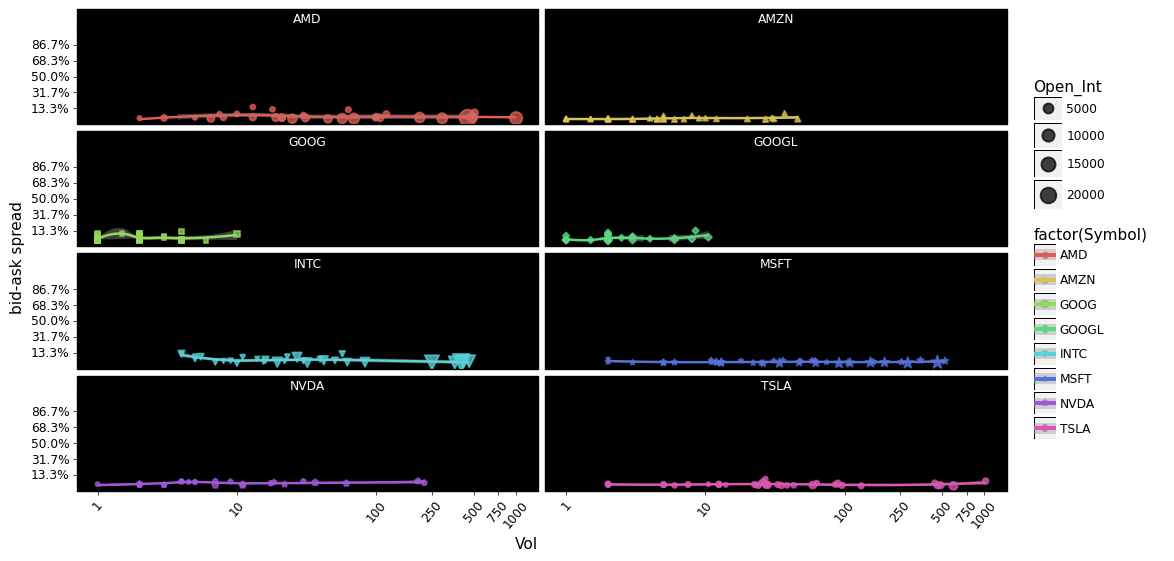

In [53]:
def facet_plot_log_points(df, x, y, color='factor(Symbol)', size='Open_Int'):
    g = (pn.ggplot(df, pn.aes(x, y, color=color))
         + pn.geom_point(pn.aes(size=size, shape='factor(Symbol)'), alpha=0.75, stroke=.75)
         + pn.stat_smooth(method='loess')
         + pn.scale_x_log10(breaks=[0,0.5,1,10,100,250,500,750,1_000])
         + pn.theme_linedraw()
         + pn.theme(figure_size=(12,6), panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50))
         + pn.scale_y_continuous(breaks=mzb.minor_breaks(5), 
                                 labels=mzf.percent_format(), 
                                 limits=(0., 1.)) 
         + pn.facet_wrap('~Symbol', ncol=2)
         + pn.ylab('bid-ask spread'))
    return g

# ------------------------------
# example use

g = facet_plot_log_points(df, x='Vol', y='Spread_Pct')
g.save(filename='../plots/facet call option bid-ask spreads - volume scatter plot-PERCENT.png')
g.draw();

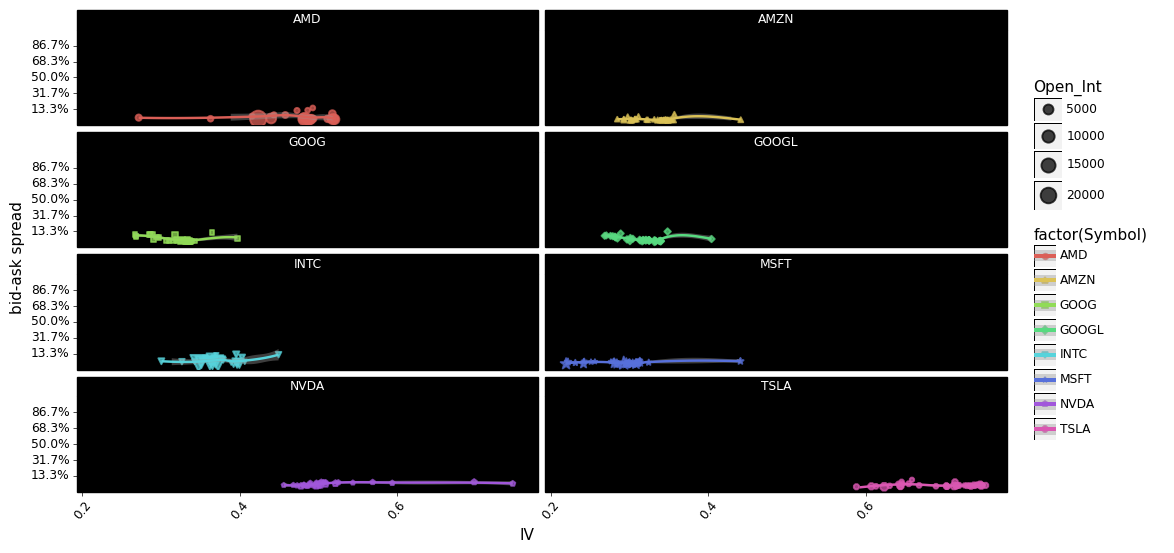

In [54]:
def facet_plot_points(df, x, y, color='factor(Symbol)', size='Open_Int'):
    g = (pn.ggplot(df, pn.aes(x, y, color=color))
         + pn.geom_point(pn.aes(size=size, shape='factor(Symbol)'), alpha=0.75, stroke=.75)
         + pn.stat_smooth(method='loess')
         + pn.theme_linedraw()
         + pn.theme(figure_size=(12,6), panel_background=pn.element_rect(fill='black'), 
                    axis_text_x=pn.element_text(rotation=50))
         + pn.scale_y_continuous(breaks=mzb.minor_breaks(5), 
                                 labels=mzf.percent_format(), 
                                 limits=(0., 1.)) 
         + pn.facet_wrap('~Symbol', ncol=2)
         + pn.ylab('bid-ask spread'))
    return g

# ------------------------------
# example use

g = facet_plot_points(df, 'IV', 'Spread_Pct')
g.save(filename='../plots/facet call-put option bid-ask spreads - volatility scatter plot.png')
g.draw();
